# Set up Google Colab Enviorment with Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robertspecht","key":"9cdbe068722d0a283c15bea7e0958920"}'}

In [ ]:
! mkdir /content/drive/MyDrive/kaggle_skinCancer

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
 ! kaggle datasets list

ref                                                                 title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20          10712        224  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           8312        170  1.0              
dataanalyst001/world-population-by-country-2024                     World Population by country 2024                     6KB  2024-07-04 09:47:58           1122         26  1.0              
ihelon/coffee-sales                          

In [ ]:
! kaggle competitions list

ref                                                                                     deadline             category             reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         $1,100,000        439           False  
https://www.kaggle.com/competitions/lmsys-chatbot-arena                                 2024-08-05 23:59:00  Research           $100,000       1177           False  
https://www.kaggle.com/competitions/isic-2024-challenge                                 2024-09-06 23:59:00  Research            $80,000        543            True  
https://www.kaggle.com/competitions/leash-BELKA                                         2024-07-08 23:59:00  Featured            $50,000       1976           False  
http

In [ ]:
! kaggle competitions download -c 'isic-2024-challenge'

 99% 1.99G/2.00G [00:20<00:00, 104MB/s] 
100% 2.00G/2.00G [00:20<00:00, 104MB/s]


In [ ]:
! unzip isic-2024-challenge.zip -d /content/drive/MyDrive/kaggle_skinCancer/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874656.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874659.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874663.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874742.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874751.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874803.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874805.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874832.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874878.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874897.jpg  
  inflating: /content/drive/MyDrive/kag

# Import the Libraries and Set up the Data

In [72]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GroupKFold
from lightgbm.callback import log_evaluation, early_stopping


%matplotlib inline

In [6]:
# load data
df_train = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/train-metadata.csv', low_memory=False)
df_test = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/test-metadata.csv', low_memory=False)
df_sub = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/sample_submission.csv')

# Exploring the Data


In [73]:
target_col = 'target'
group_col = 'patient_id'

categorical_cols = [
    'tbp_lv_location_simple',
    'tbp_lv_location',
    'tbp_tile_type',
#     'image_type', # Single value
    'attribution',
    'anatom_site_general',
    'sex',
    'copyright_license'
]

features_cols = [
    'age_approx',
    'sex',
    'anatom_site_general',
    'clin_size_long_diam_mm',
#     'image_type', # Single value
    'tbp_tile_type',
    'tbp_lv_A',
    'tbp_lv_Aext',
    'tbp_lv_B',
    'tbp_lv_Bext',
    'tbp_lv_C',
    'tbp_lv_Cext',
    'tbp_lv_H',
    'tbp_lv_Hext',
    'tbp_lv_L',
    'tbp_lv_Lext',
    'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean',
    'tbp_lv_deltaA',
    'tbp_lv_deltaB',
    'tbp_lv_deltaL',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_eccentricity',
    'tbp_lv_location',
    'tbp_lv_location_simple',
    'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border',
    'tbp_lv_norm_color',
    'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max',
    'tbp_lv_stdL',
    'tbp_lv_stdLExt',
    'tbp_lv_symm_2axis',
    'tbp_lv_symm_2axis_angle',
    'tbp_lv_x',
    'tbp_lv_y',
    'tbp_lv_z',
    'attribution',
    'copyright_license',
]

# Seperating the Data

In [74]:
# Separating features and target
X = df_train[features_cols].copy()  # Making a copy to avoid modifying the original dataframe
y = df_train[target_col]
groups = df_train[group_col]

category_encoder = OrdinalEncoder(
    categories = 'auto', dtype = int, handle_unknown='use_encoded_value', unknown_value = -2, encoded_missing_value = -1)
X_cat = category_encoder.fit_transform(X[categorical_cols])
X_cat


array([[ 4, 12,  1, ...,  2,  1,  1],
       [ 0,  0,  1, ...,  1,  1,  1],
       [ 5, 16,  0, ...,  3,  1,  1],
       ...,
       [ 6, 19,  0, ...,  0,  0,  1],
       [ 6, 18,  0, ...,  0,  0,  2],
       [ 2,  5,  0, ...,  2,  1,  1]])

In [75]:
X.head(5)

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,60.0,male,lower extremity,3.04,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY
1,60.0,male,head/neck,1.10,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY
2,60.0,male,posterior torso,3.40,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY
3,65.0,male,anterior torso,3.22,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0
4,55.0,male,anterior torso,2.73,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY


In [76]:
X_cat

array([[ 4, 12,  1, ...,  2,  1,  1],
       [ 0,  0,  1, ...,  1,  1,  1],
       [ 5, 16,  0, ...,  3,  1,  1],
       ...,
       [ 6, 19,  0, ...,  0,  0,  1],
       [ 6, 18,  0, ...,  0,  0,  2],
       [ 2,  5,  0, ...,  2,  1,  1]])

In [77]:

for c, cat in enumerate(categorical_cols):
  X[cat] = X_cat[:, c]
X.head(5)

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,60.0,1,2,3.04,1,20.244422,16.261975,26.922447,23.954773,33.684638,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,4,1
1,60.0,1,1,1.10,1,31.712570,25.364740,26.331000,24.549290,41.219030,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,4,1
2,60.0,1,3,3.40,0,22.575830,17.128170,37.970460,33.485410,44.174920,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,4,1
3,65.0,1,0,3.22,0,14.242329,12.164757,21.448144,21.121356,25.746200,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0,0
4,55.0,1,0,2.73,1,24.725520,20.057470,26.464900,25.710460,36.217980,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,4,1


In [78]:
lgb_data = lgb.Dataset(X, label=y, categorical_feature=categorical_cols, free_raw_data=False)

In [83]:
# Based on: https://www.kaggle.com/code/metric/isic-pauc-abovetpr
from sklearn.metrics import roc_auc_score

def score(solution: np.ndarray, submission: np.ndarray, min_tpr: float=0.80) -> float:
    v_gt = abs(solution-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return(partial_auc)

In [84]:
def pauc_80(preds, data):
    score_value = score(data.get_label(), preds, min_tpr=0.8)

    return 'pauc_80', score_value, True

In [85]:
# Setting up the cross-validation
params = {
    'objective': 'binary',
    'metric': 'none',
    'verbose': -1,

    # Here are my magic numbers... try yours!
    'learning_rate': 0.01,
    'num_leaves': 31,
    'min_data_in_leaf': 50,
    'pos_bagging_fraction': 0.75,
    'neg_bagging_fraction': 0.05,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'lambda_l1': 0.25,
    'lambda_l2': 1.0
}

In [86]:
# GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=5)

In [87]:

cv_results = lgb.cv(
    params,
    lgb_data,
    folds=group_kfold.split(X, y, groups),
    feval=pauc_80,
    num_boost_round=1000,
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(10)],
    stratified=False
)

Training until validation scores don't improve for 50 rounds
[10]	cv_agg's valid pauc_80: 0.138826 + 0.00728749
[20]	cv_agg's valid pauc_80: 0.140842 + 0.00499539
[30]	cv_agg's valid pauc_80: 0.144489 + 0.00568697
[40]	cv_agg's valid pauc_80: 0.145303 + 0.00525604
[50]	cv_agg's valid pauc_80: 0.146573 + 0.00535188
[60]	cv_agg's valid pauc_80: 0.147156 + 0.00521279
[70]	cv_agg's valid pauc_80: 0.148134 + 0.00479917
[80]	cv_agg's valid pauc_80: 0.149214 + 0.00412206
[90]	cv_agg's valid pauc_80: 0.150192 + 0.00376046
[100]	cv_agg's valid pauc_80: 0.150428 + 0.00369107
[110]	cv_agg's valid pauc_80: 0.151183 + 0.00366591
[120]	cv_agg's valid pauc_80: 0.151809 + 0.0034276
[130]	cv_agg's valid pauc_80: 0.151978 + 0.00342944
[140]	cv_agg's valid pauc_80: 0.152872 + 0.00328448
[150]	cv_agg's valid pauc_80: 0.153128 + 0.00322809
[160]	cv_agg's valid pauc_80: 0.153605 + 0.00310902
[170]	cv_agg's valid pauc_80: 0.153893 + 0.0032687
[180]	cv_agg's valid pauc_80: 0.15415 + 0.00313021
[190]	cv_agg's 

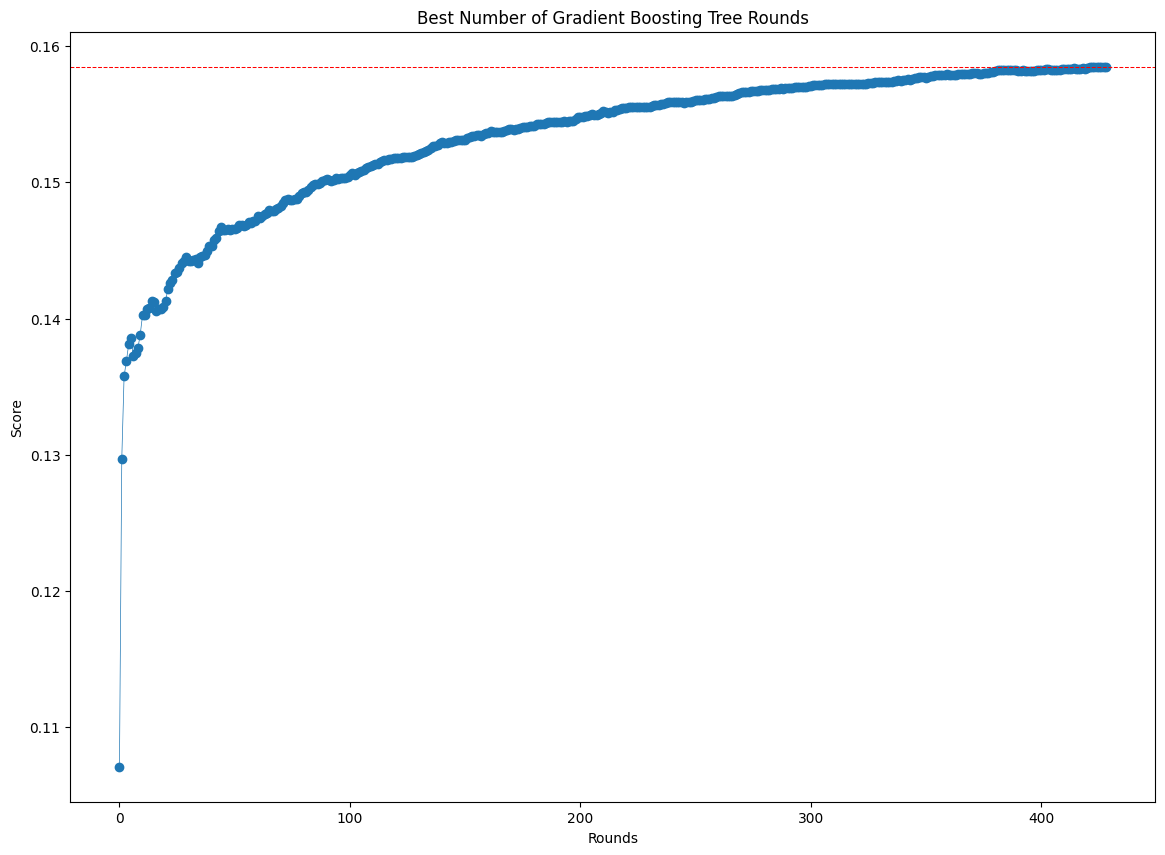

In [94]:
plt.figure(figsize= (14,10))
plt.plot(cv_results['valid pauc_80-mean'], linewidth = .5, marker = 'o')
plt.axhline(y = max(cv_results['valid pauc_80-mean']), color = 'red', linewidth = .75, linestyle = '--')
plt.title('Best Number of Gradient Boosting Tree Rounds')
plt.xlabel('Rounds')
plt.ylabel('Score')
plt.show()

In [95]:
final_model = lgb.train(
    params,
    lgb_data,
    num_boost_round= len(cv_results['valid pauc_80-mean'])
)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

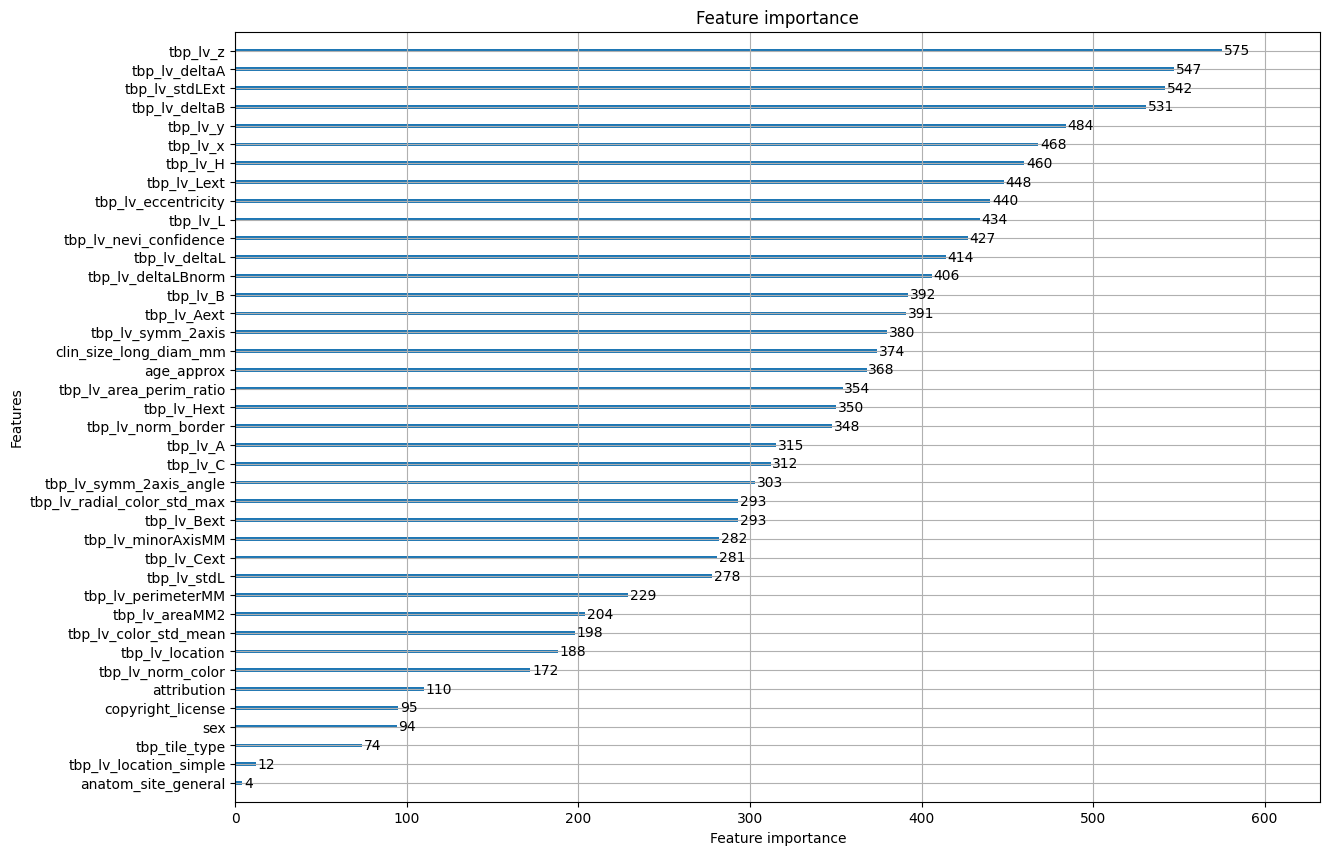

In [96]:
lgb.plot_importance(final_model, figsize = (14,10))

In [97]:
X_test = df_test[features_cols].copy()
X_cat_test = category_encoder.transform(X_test[categorical_cols])
for c, cat in enumerate(categorical_cols):
  X_test[cat] = X_cat_test[:,c]

In [98]:
df_test['target'] = final_model.predict(X_test)

In [101]:
df_test[['isic_id', 'target']].to_csv('submission.csv', index = False)
!head submission.csv

isic_id,target
ISIC_0015657,0.0016762392960367343
ISIC_0015729,0.0006318414146053477
ISIC_0015740,0.004018267890348972
